In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")
import numpy as np
import matplotlib.pyplot as plt

import src.atomic_worlds.big_small as bs
import src.utils.param_sweep as ps
# import src.utils.transition_matrix as tm
import src.utils.make_environment as make_env
import src.worlds.mdp2d as mdp2d

from src.utils.visualization import plot_environment


/home/paul/.local/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
# Set the number of scales and gammas to use
granularity = 20  # 5, 10, 20

# Set up parameters to search over
probs = np.linspace(0.4, 0.99, granularity)
gammas = np.linspace(0.4, 0.99, granularity)

In [3]:
def convert_to_environment(world: mdp2d.Experiment_2D):
    """Converts a world to an environment."""
    N = world.height
    M = world.width

    T = world.mdp.T

    environment = make_env.Environment(
        N=N,
        M=M,
        T_true=T,
        wall_states=[],
        R_sample_mean=None,
        start_state=0,
        n_walls=0,
        R_true=world.rewards,
    )

    return environment

In [4]:
def plot_bmap(
    world: mdp2d.Experiment_2D,
    idx_map=None,
    p2idx_override=None,
    start_state=0,
    ax=None,
):
    result = ps.run_experiment(
        experiment=world,
        params=world.params,
        gammas=gammas,
        probs=probs,
        start_state=start_state,
    )

    data = result.data

    if idx_map:
        new_data = np.zeros_like(data)
        for fromm, to in idx_map.items():
            new_data[data == fromm] = to
        data = new_data

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    ps.make_general_strategy_heatmap(
        results=data,
        probs=probs,
        p2idx=p2idx_override,
        title=f"",
        ax=ax,
        gammas=gammas,
        annot=False,
        ax_labels=False,
        num_ticks=5,
        legend=False
    )
    return result

## Define Custom worlds


In [5]:
from src.worlds.mdp2d import Experiment_2D

def make_world(
    height: int,
    width: int,
    rewards: np.array,
    absorbing_states: list,
    wall_states: list
) -> Experiment_2D:

    experiment = Experiment_2D(
        height,
        width,
        rewards = rewards,
        absorbing_states = absorbing_states,
        wall_states=wall_states
    )

    return experiment

In [8]:
height = 5
width = 6
rewards = np.zeros((height, width))
wall_states = np.zeros((height, width))

rewards[4,0] = 2
rewards[4,5] = 4
rewards = rewards.flatten()

absorbing_states = np.where(rewards > 0)[0]

wall_states[2,1] = 1
wall_states[2,0] = 1
wall_states = wall_states.flatten()
wall_states = np.where(wall_states > 0)[0]


custom_world = make_world(height=height,
                          width=width,
                          rewards=rewards,
                          absorbing_states=absorbing_states,
                          wall_states=wall_states)

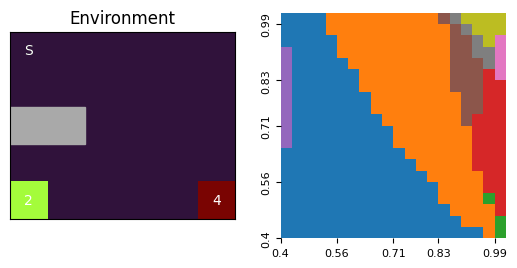

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2)

new_env = convert_to_environment(custom_world)

plot_environment(new_env.R_true.reshape(height, width), wall_states=wall_states, ax= axs[0])
out = plot_bmap(
    world=custom_world,
    ax=axs[1],
)

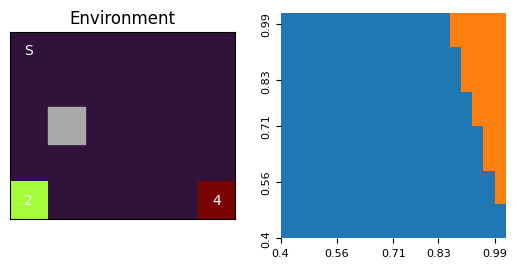

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2)

new_env = convert_to_environment(custom_world)

plot_environment(new_env.R_true.reshape(height, width), wall_states=wall_states, ax= axs[0])
out = plot_bmap(
    world=custom_world,
    ax=axs[1],
)

## Example of a Different BM

In [9]:
def cobb_douglas(s, a, b, n_rows, n_cols):
    '''
    Models Cobb Douglas preferences
    '''
    row_state = s//n_rows
    col_state = s%n_cols
    
    return (row_state+1)**a*(col_state+1)**b 

###  Comparison of Env.Design with and without Behavior Maps

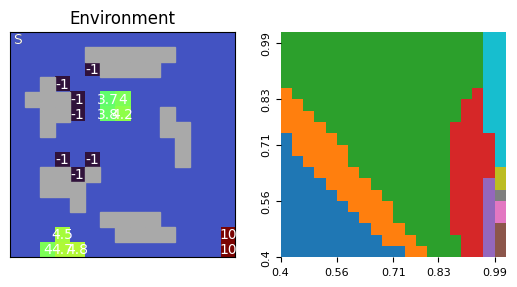

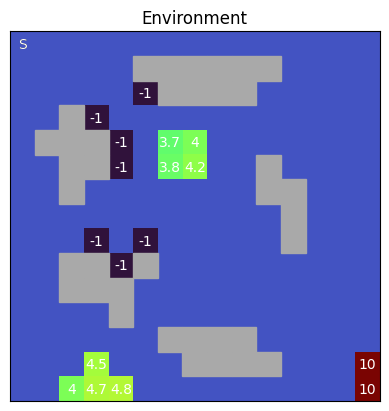

In [16]:
height = 15
width = 15
rewards = np.zeros((height, width))
wall_states = np.zeros((height, width))


#reward blop in the middle
rewards[4,6] = 3.7
rewards[5,6] = 3.8
rewards[4,7] = 4
rewards[5,7] = 4.2


absorbing_states = np.where(rewards > 0)[0]


#wall blop top left corner
wall_states[3,2] = 1
wall_states[4,1] = 1
wall_states[4,2] = 1
wall_states[4,3] = 1
wall_states[4,1] = 1
wall_states[4,2] = 1
wall_states[4,3] = 1
wall_states[5,3] = 1
wall_states[5,2] = 1
wall_states[6,2] = 1

rewards[5,4] = -1
rewards[2,5] = -1


#wall blop middle left
wall_states[9,2] = 1
wall_states[9,3] = 1
wall_states[9,3] = 1
wall_states[9,5] = 1
wall_states[10,2] = 1
wall_states[10,3] = 1
wall_states[10,4] = 1
wall_states[11,4] = 1

rewards[8,3] = -1
rewards[9,4] = -1
rewards[8,5] = -1


#long wall along top
wall_states[1,5] = 1
wall_states[1,6] = 1
wall_states[1,7] = 1
wall_states[1,8] = 1
wall_states[1,9] = 1
wall_states[1,10] = 1
wall_states[2,6] = 1
wall_states[2,7] = 1
wall_states[2,8] = 1
wall_states[2,9] = 1

rewards[3,3] = -1
rewards[4,4] = -1

rewards[8,3] = -1
rewards[9,4] = -1
rewards[8,5] = -1


#wall blop middle right
wall_states[5,10] = 1
wall_states[6,10] = 1
wall_states[6,10] = 1
wall_states[6,10] = 1
wall_states[6,10] = 1
wall_states[6,10] = 1
wall_states[6,11] = 1
wall_states[7,11] = 1
wall_states[7,11] = 1
wall_states[8,11] = 1


#reward blop bottom left
rewards[14,2] = 4
rewards[13,3] = 4.5
rewards[14,3] = 4.7
rewards[14,4] = 4.8




#long wall along top
wall_states[12,6] = 1
wall_states[12,7] = 1
wall_states[12,8] = 1
wall_states[12,9] = 1
wall_states[13,10] = 1
wall_states[13,7] = 1
wall_states[13,8] = 1
wall_states[13,9] = 1


#reawrds bottom right corner
rewards[13,14] = 10
rewards[14, 14] = 10




wall_states = wall_states.flatten()
rewards = rewards.flatten()

wall_states = np.where(wall_states > 0)[0]


custom_world = make_world(height=height,
                          width=width,
                          rewards=rewards,
                          absorbing_states=absorbing_states,
                          wall_states=wall_states)

new_env = convert_to_environment(custom_world)

fig, axs = plt.subplots(nrows=1, ncols=2)


plot_environment(new_env.R_true.reshape(height, width), wall_states=wall_states, ax= None)

plot_environment(new_env.R_true.reshape(height, width), wall_states=wall_states, ax= axs[0])
out = plot_bmap(
    world=custom_world,
    ax=axs[1],
)

In [17]:
out

ExperimentResult(data=array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  2,  2,
         3,  3,  4,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,
         3,  3,  4,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  3,
         3,  3,  4,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  3,
         3,  3,  4,  6],
       [ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,
         3,  3,  4,  6],
       [ 0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,
         3,  3,  4,  7],
       [ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  3,
         3,  3,  4,  8],
       [ 0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,
         3,  3,  3,  8],
       [ 0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
         3,  3,  3,  9],
       [ 0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
         3,  3,  3,  9],
       [